In [1]:
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install matplotlib

In [2]:
import os
import pandas as pd
import numpy as np

from sklearn.metrics import (
    brier_score_loss, 
    roc_auc_score,
    average_precision_score,
    roc_curve,
    precision_recall_curve
)

from sklearn.calibration import calibration_curve

import matplotlib.pyplot as plt

# For nicer printing
pd.set_option("display.max_columns", 50)

In [3]:
# Load CIMIS data 

DATA_DIR = "./cimis-hourly-data-multiple-stations/"

def file_to_df(file_name: str):
    # Load CSV file into a pandas DataFrame
    return pd.read_csv(file_name)

def get_datasets():
    # Uses shell commands, works in Jupyter
    !touch buffer.tmp
    !(ls $DATA_DIR | grep "csv") > buffer.tmp
    name_to_data = dict()  # Dictionary for Name to Data
    # Read the buffer.tmp and create Name to Data pairs
    with open("buffer.tmp", "r") as file:
        contents = [f for f in file.read().split("\n") if f]
        for content in contents:
            file_name = content.split(".")[0]
            if "all" not in file_name:
                name_to_data[file_name] = file_to_df(DATA_DIR + content)
    !rm -f buffer.tmp
    return name_to_data

datasets = get_datasets()

# Individual dataset names (one per station, e.g. '80-fresnostate')
dataset_names = [d for d in datasets.keys() if "all" not in d]

# Remove columns that contain "qc" using one sample dataset
sample_name = dataset_names[0]
columns_to_remove = [col for col in datasets[sample_name].columns.tolist() if "qc" in col]

for name in datasets:
    datasets[name].drop(columns=columns_to_remove, inplace=True)

# Combine into a single DataFrame, ensuring 'Stn Id' exists
dfs = []
for name, d in datasets.items():
    df_station = d.copy()
    if "Stn Id" not in df_station.columns:
        # If the CSV does not include the station ID column, create one from the key
        df_station["Stn Id"] = name
    dfs.append(df_station)

df = pd.concat(dfs, ignore_index=True)

print("Combined df shape:", df.shape)
print(df.columns)
df.head()

Combined df shape: (2367360, 16)
Index(['Stn Id', 'Stn Name', 'CIMIS Region', 'Date', 'Hour (PST)', 'Jul',
       'ETo (mm)', 'Precip (mm)', 'Sol Rad (W/sq.m)', 'Vap Pres (kPa)',
       'Air Temp (C)', 'Rel Hum (%)', 'Dew Point (C)', 'Wind Speed (m/s)',
       'Wind Dir (0-360)', 'Soil Temp (C)'],
      dtype='object')


,Stn Id,Stn Name,CIMIS Region,Date,Hour (PST),Jul,ETo (mm),Precip (mm),Sol Rad (W/sq.m),Vap Pres (kPa),Air Temp (C),Rel Hum (%),Dew Point (C),Wind Speed (m/s),Wind Dir (0-360),Soil Temp (C)
0,105,Westlands,San Joaquin Valley,9/28/2010,100,271,0.06,0.0,0.0,0.9,20.6,35.0,4.7,1.7,253.0,22.8
1,105,Westlands,San Joaquin Valley,9/28/2010,200,271,0.05,0.0,0.0,0.9,20.0,38.0,5.3,1.8,95.0,22.5
2,105,Westlands,San Joaquin Valley,9/28/2010,300,271,0.04,0.0,0.0,0.9,19.0,42.0,5.9,1.3,141.0,22.2
3,105,Westlands,San Joaquin Valley,9/28/2010,400,271,0.03,0.0,0.0,0.9,18.8,41.0,5.2,1.0,186.0,21.9
4,105,Westlands,San Joaquin Valley,9/28/2010,500,271,0.04,0.0,0.0,0.7,16.6,40.0,2.8,1.4,254.0,21.6


In [8]:
# Build Datetime and frost_now with handling for 24:00 ---

TEMP_COL = "Air Temp (C)"   

# Extract hour from integers like 100, 1300, 2400
raw_hours = df["Hour (PST)"].astype(int)

# hour_int = 0–23 normally, but 24 → 0 of next day
df["Hour_int"] = (raw_hours // 100)

# Identify rows where the hour is 24
mask_24 = df["Hour_int"] == 24

# Set hour=0 for parsing
df.loc[mask_24, "Hour_int"] = 0

# Parse date with hour=0 (even for original 24:00 rows)
df["Datetime"] = pd.to_datetime(
    df["Date"] + " " + df["Hour_int"].astype(str).str.zfill(2) + ":00",
    format="%m/%d/%Y %H:%M"
)

# For rows that were originally 24:00 → add 1 day
df.loc[mask_24, "Datetime"] = df.loc[mask_24, "Datetime"] + pd.Timedelta(days=1)

# Final sorting
df = df.sort_values(["Stn Id", "Datetime"]).reset_index(drop=True)

# Create frost flag
df["frost_now"] = (df[TEMP_COL] < 0).astype(int)

df[["Stn Id", "Date", "Hour (PST)", "Datetime", TEMP_COL, "frost_now"]].head(10)

,Stn Id,Date,Hour (PST),Datetime,Air Temp (C),frost_now
0,2,9/28/2010,100,2010-09-28 01:00:00,20.4,0
1,2,9/28/2010,200,2010-09-28 02:00:00,20.0,0
2,2,9/28/2010,300,2010-09-28 03:00:00,18.5,0
3,2,9/28/2010,400,2010-09-28 04:00:00,18.0,0
4,2,9/28/2010,500,2010-09-28 05:00:00,17.4,0
5,2,9/28/2010,600,2010-09-28 06:00:00,16.9,0
6,2,9/28/2010,700,2010-09-28 07:00:00,17.3,0
7,2,9/28/2010,800,2010-09-28 08:00:00,22.1,0
8,2,9/28/2010,900,2010-09-28 09:00:00,26.0,0
9,2,9/28/2010,1000,2010-09-28 10:00:00,28.8,0


In [9]:
# Build frost labels for multiple horizons

HORIZONS = [3, 6, 12, 24]

# Ensure temperature is numeric
df[TEMP_COL] = pd.to_numeric(df[TEMP_COL], errors="coerce")

def add_frost_labels(df, horizons, temp_col="Air Temp (C)"):
    df = df.copy()
    df = df.sort_values(["Stn Id", "Datetime"]).reset_index(drop=True)
    
    for H in horizons:
        label_col = f"frost_next_{H}h"
        labels = []

        for stn_id, g in df.groupby("Stn Id", sort=False):
            temps = g[temp_col].to_numpy()
            n = len(temps)
            lab = np.zeros(n, dtype=int)

            for i in range(n):
                j_end = min(n, i + H + 1)   # exclusive
                window = temps[i+1:j_end]   # (t, t+H]

                # Keep only non-NaN values
                window_valid = window[~np.isnan(window)]

                if len(window_valid) > 0 and window_valid.min() < 0:
                    lab[i] = 1
                else:
                    lab[i] = 0

            labels.append(pd.Series(lab, index=g.index, name=label_col))

        labels = pd.concat(labels).sort_index()
        df[label_col] = labels

    return df

df = add_frost_labels(df, HORIZONS, temp_col=TEMP_COL)
df[["Stn Id", "Datetime", TEMP_COL] + [f"frost_next_{h}h" for h in HORIZONS]].head()

,Stn Id,Datetime,Air Temp (C),frost_next_3h,frost_next_6h,frost_next_12h,frost_next_24h
0,2,2010-09-28 01:00:00,20.4,0,0,0,0
1,2,2010-09-28 02:00:00,20.0,0,0,0,0
2,2,2010-09-28 03:00:00,18.5,0,0,0,0
3,2,2010-09-28 04:00:00,18.0,0,0,0,0
4,2,2010-09-28 05:00:00,17.4,0,0,0,0


## Baseline Probabilities ##
Compute climatology, dew point, and persistence baselines for comparison 

In [10]:
# Testing optimal timestamp value for dataset
# df["Datetime"].min(), df["Datetime"].max() # uncomment to run

# (Timestamp('2010-09-28 01:00:00'), Timestamp('2025-09-29 00:00:00'))
# Total ~ 15 years
# 80% point ~2022 
# 70% ~2018-19
# we want test to be atleast 3-5 frost seasons

(Timestamp('2010-09-28 01:00:00'), Timestamp('2025-09-29 00:00:00'))

In [11]:
# Time-based train / test split

CUTOFF_DATE = "2019-01-01"  # adjust as needed
# choose a cutoff about 70-80% through a dataset timeline
# e.g. for 2010-2025, 80% point ~= 2017
# you want a training cutoff early BEFORE the data you are testing on

train = df[df["Datetime"] < CUTOFF_DATE].copy()
test  = df[df["Datetime"] >= CUTOFF_DATE].copy()

len(train), len(test)

(1303326, 1064034)

In [12]:
# Climatology baseline
# For each horizon H:
# Compute P(frost_next_Hh | month) on train
# Apply to test, fallback to global rate if needed

for split in [train, test]:
    split["month"] = split["Datetime"].dt.month

for H in HORIZONS:
    label_col = f"frost_next_{H}h"
    clim_col  = f"p_clim_{H}h"

    global_rate = train[label_col].mean()
    monthly_rate = train.groupby("month")[label_col].mean()

    test[clim_col] = test["month"].map(monthly_rate)
    test[clim_col] = test[clim_col].fillna(global_rate)

test[["Datetime", "month"] + [f"p_clim_{h}h" for h in HORIZONS]].head()

,Datetime,month,p_clim_3h,p_clim_6h,p_clim_12h,p_clim_24h
72407,2019-01-01 00:00:00,1,0.05619,0.077182,0.117944,0.173984
72408,2019-01-01 01:00:00,1,0.05619,0.077182,0.117944,0.173984
72409,2019-01-01 02:00:00,1,0.05619,0.077182,0.117944,0.173984
72410,2019-01-01 03:00:00,1,0.05619,0.077182,0.117944,0.173984
72411,2019-01-01 04:00:00,1,0.05619,0.077182,0.117944,0.173984


In [16]:
# Dew-point empirical rule baseline 
# For each horizon H: 
# Bin dew point on train
# Use empirical P(frost_next_Hh | Td bin) as baseline probability

DEW_COL = "Dew Point (C)"  

dew_bins = np.arange(-20, 21, 2)  # -20 to +20 by 2°C, adjust if needed

for H in HORIZONS:
    label_col = f"frost_next_{H}h"
    dew_col   = f"p_dew_{H}h"

    # Bin dew point in train and test
    train["Td_bin"] = pd.cut(train[DEW_COL], bins=dew_bins, include_lowest=True)
    test["Td_bin"]  = pd.cut(test[DEW_COL],  bins=dew_bins, include_lowest=True)

    # Empirical P(frost | Td_bin) on train
    dew_table = train.groupby("Td_bin", observed=False)[label_col].mean()

    # Global frost rate as fallback
    global_rate = train[label_col].mean()

    # Map Td_bin → probability (this is a Series indexed by Td_bin categories)
    prob = test["Td_bin"].map(dew_table)

    # Make sure it's a float Series, not categorical
    prob = prob.astype("float64")

    # Fill NaNs (bins not seen in train) with global rate, still float
    prob = prob.fillna(float(global_rate))

    # Finally assign plain float values into the test column
    test[dew_col] = prob.values

# Clean up temporary bin column
train.drop(columns=["Td_bin"], inplace=True, errors="ignore")
test.drop(columns=["Td_bin"], inplace=True, errors="ignore")

test[[DEW_COL] + [f"p_dew_{h}h" for h in HORIZONS]].head()


,Dew Point (C),p_dew_3h,p_dew_6h,p_dew_12h,p_dew_24h
72407,-2.5,0.235690,0.284197,0.357198,0.450512
72408,-3.3,0.235690,0.284197,0.357198,0.450512
72409,-4.1,0.251292,0.306622,0.388028,0.486446
72410,-3.6,0.235690,0.284197,0.357198,0.450512
72411,-3.9,0.235690,0.284197,0.357198,0.450512


In [17]:
# Persistence baseline
# Very simple rule: 
# If freezing now -> P(frost_next_Hh) = 1
# Else -> 0

for H in HORIZONS:
    persist_col = f"p_persist_{H}h"
    test[persist_col] = test["frost_now"].astype(float)

test[["frost_now"] + [f"p_persist_{h}h" for h in HORIZONS]].head()

,frost_now,p_persist_3h,p_persist_6h,p_persist_12h,p_persist_24h
72407,1,1.0,1.0,1.0,1.0
72408,1,1.0,1.0,1.0,1.0
72409,1,1.0,1.0,1.0,1.0
72410,1,1.0,1.0,1.0,1.0
72411,1,1.0,1.0,1.0,1.0


In [19]:
# Save baseline probabilities (standalone use)
# Export a CSV with: 
# Stn Id, Datetime
# Labels frost_next_Hh
# Baselines: climatology, dew, persistence
# Used for analysis later

baseline_cols = []
for H in HORIZONS:
    baseline_cols += [
        f"frost_next_{H}h",
        f"p_clim_{H}h",
        f"p_dew_{H}h",
        f"p_persist_{H}h",
    ]

baseline_df = test[["Stn Id", "Datetime"] + baseline_cols].copy()

baseline_path = "frost_baselines_test.csv"
baseline_df.to_csv(baseline_path, index=False)

baseline_path

'frost_baselines_test.csv'

## Creating plots for Brier, ROC-AUC, PR-AUC, and ECE for each baseline & horizon
Assuming frost_baselines_test.csv
exists already

Saving all plots to: baseline_plots/


,horizon,model,brier,roc_auc,pr_auc,ece
0,3,p_clim_3h,0.008603,0.848047,0.027040,0.006140
1,3,p_dew_3h,0.008294,0.958563,0.095542,0.005244
2,3,p_persist_3h,0.006036,0.727601,0.335393,0.004573
3,6,p_clim_6h,0.012976,0.848753,0.040825,0.007768
4,6,p_dew_6h,0.012308,0.947382,0.117066,0.006448
5,6,p_persist_6h,0.010360,0.650270,0.228274,0.008908
6,12,p_clim_12h,0.021568,0.850786,0.068109,0.015915
7,12,p_dew_12h,0.020188,0.921679,0.143982,0.009752
8,12,p_persist_12h,0.018971,0.589480,0.148714,0.017523
9,24,p_clim_24h,0.035320,0.855103,0.115214,0.021723


Saved: baseline_plots/brier_3h.png


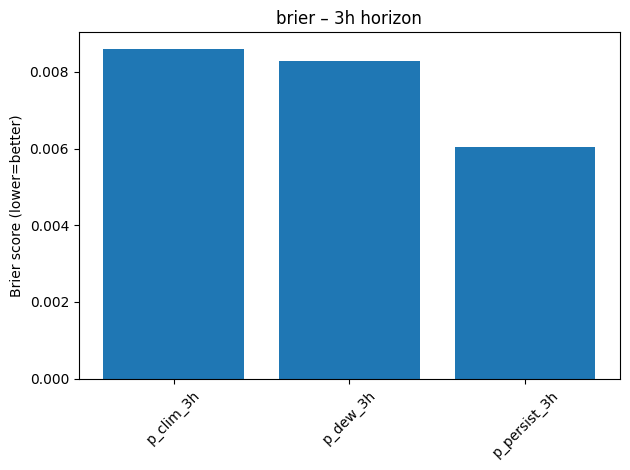

Saved: baseline_plots/ece_3h.png


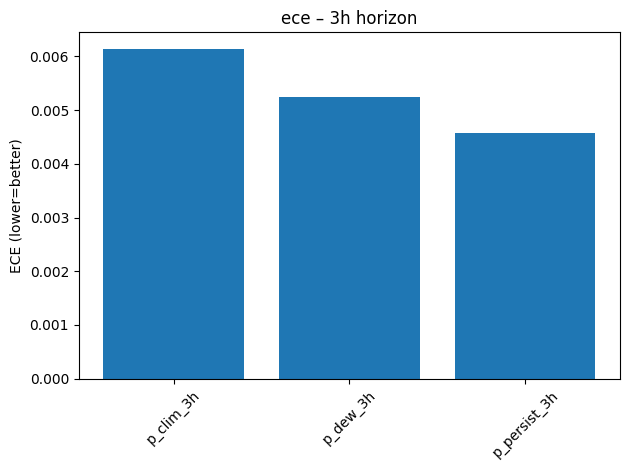

Saved: baseline_plots/roc_auc_3h.png


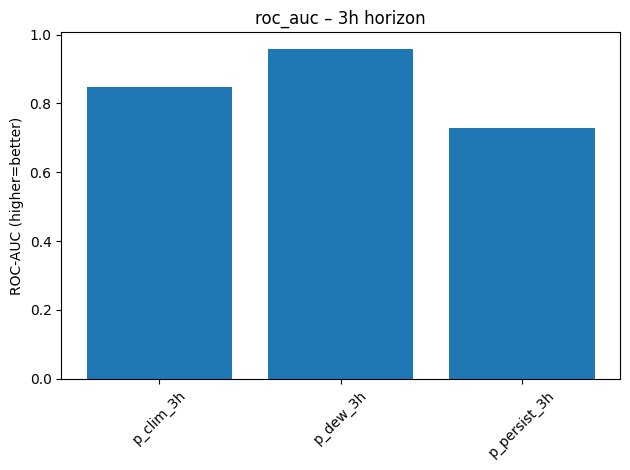

Saved: baseline_plots/pr_auc_3h.png


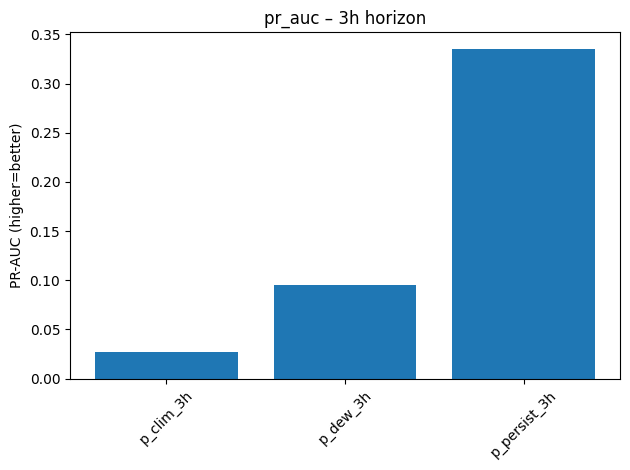

Saved: baseline_plots/brier_6h.png


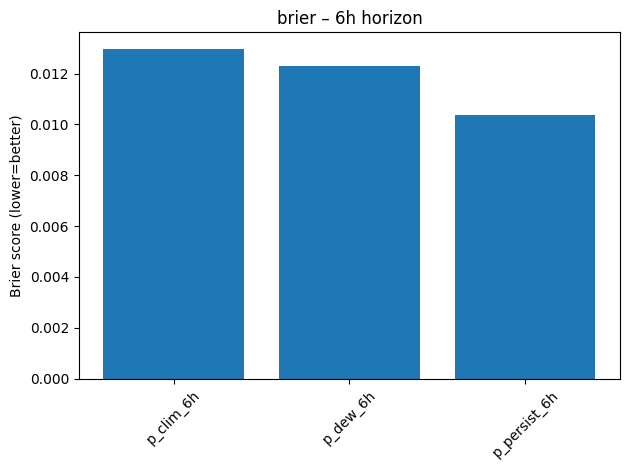

Saved: baseline_plots/ece_6h.png


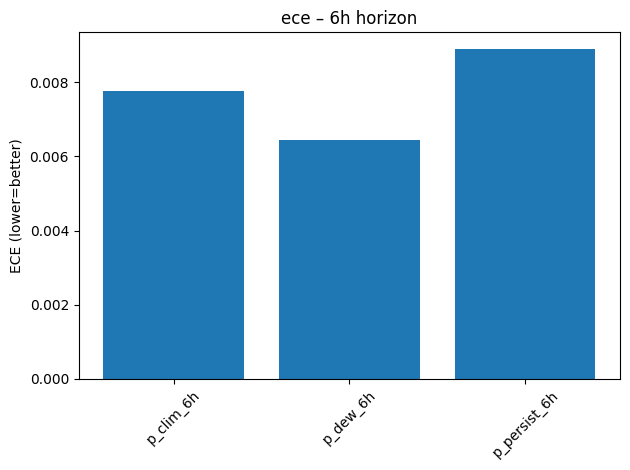

Saved: baseline_plots/roc_auc_6h.png


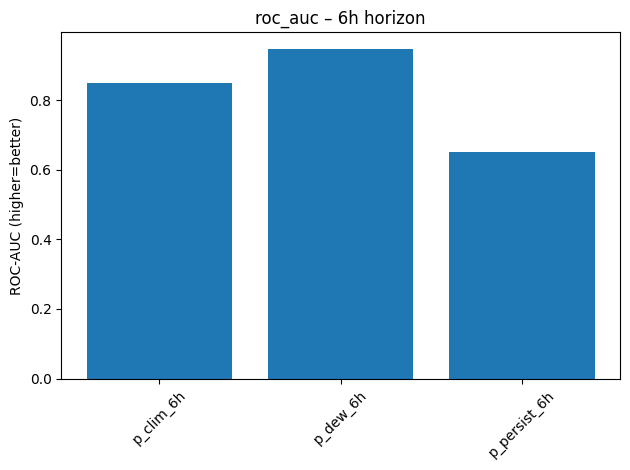

Saved: baseline_plots/pr_auc_6h.png


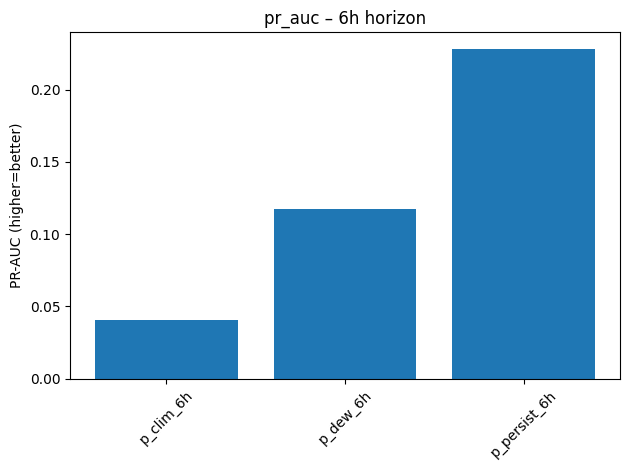

Saved: baseline_plots/brier_12h.png


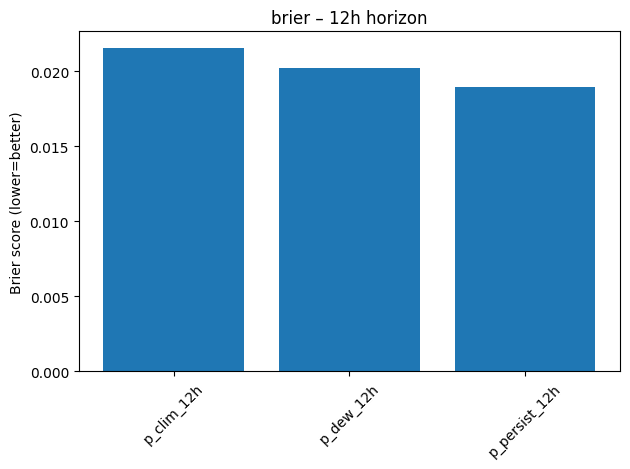

Saved: baseline_plots/ece_12h.png


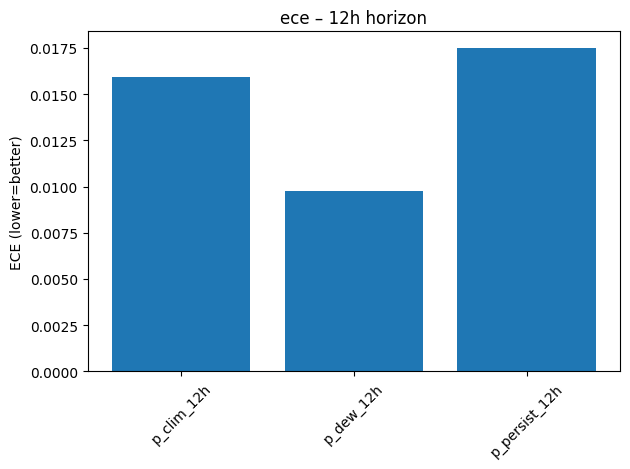

Saved: baseline_plots/roc_auc_12h.png


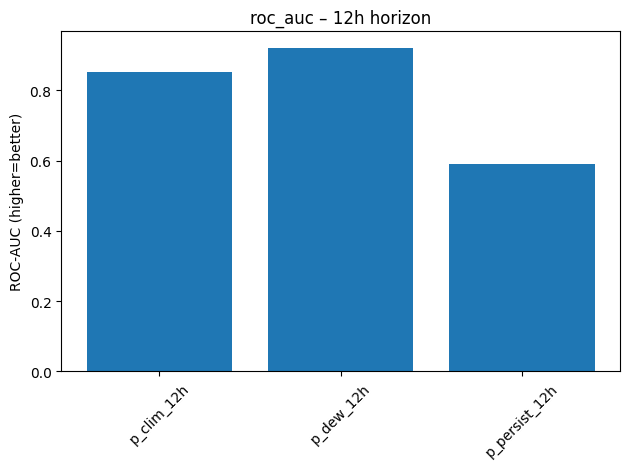

Saved: baseline_plots/pr_auc_12h.png


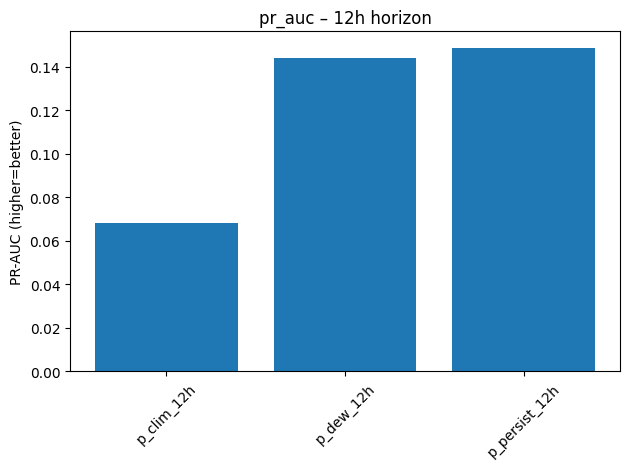

Saved: baseline_plots/brier_24h.png


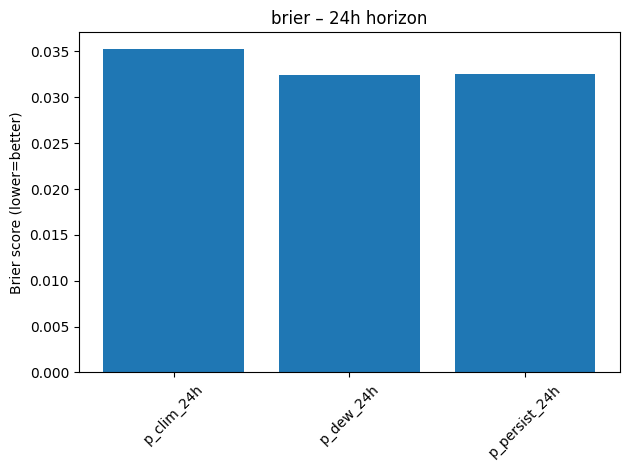

Saved: baseline_plots/ece_24h.png


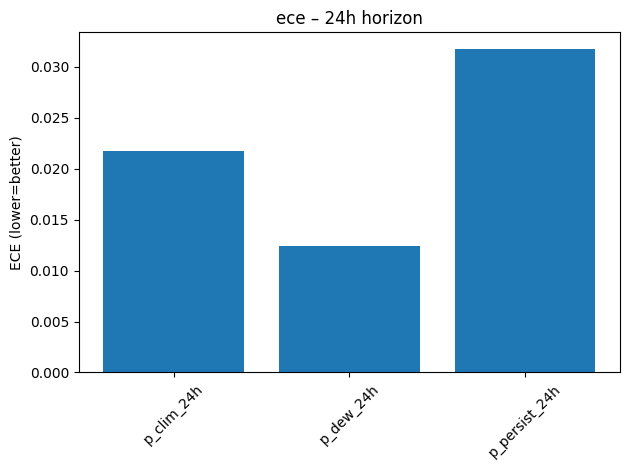

Saved: baseline_plots/roc_auc_24h.png


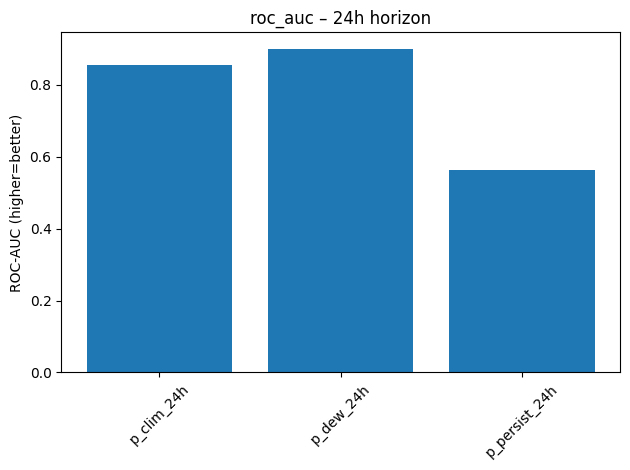

Saved: baseline_plots/pr_auc_24h.png


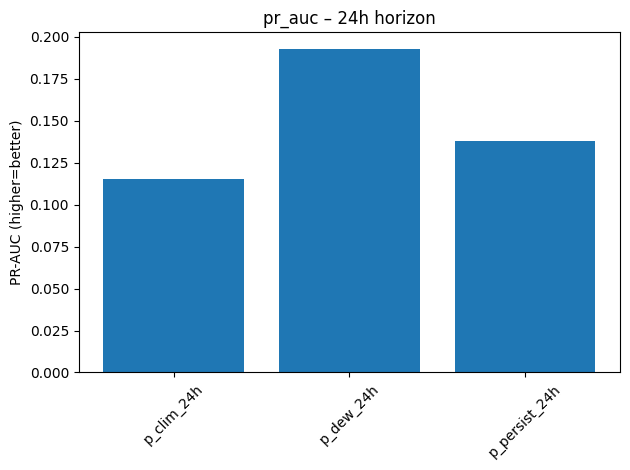

Saved: baseline_plots/reliability_3h.png


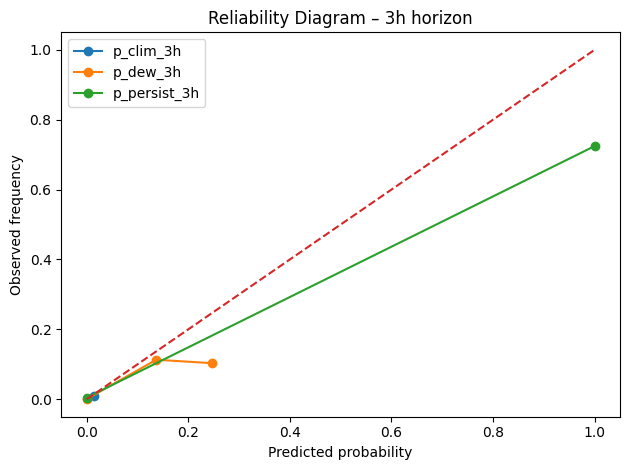

Saved: baseline_plots/reliability_6h.png


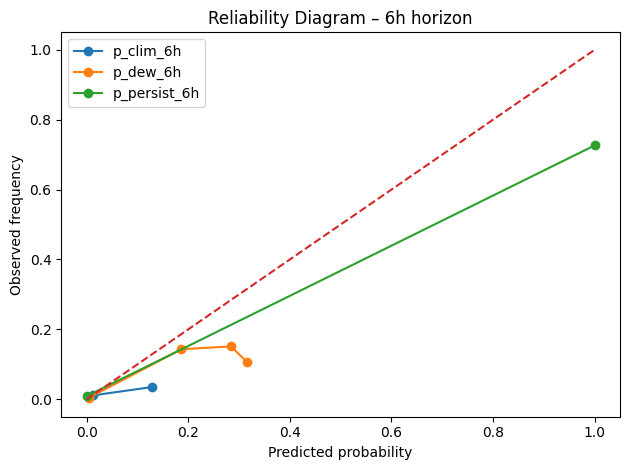

Saved: baseline_plots/reliability_12h.png


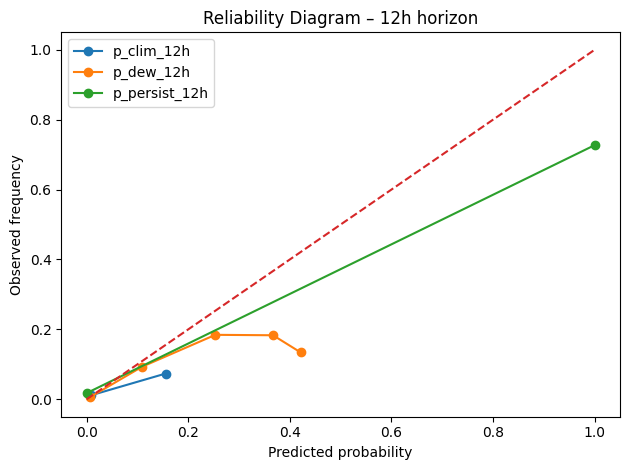

Saved: baseline_plots/reliability_24h.png


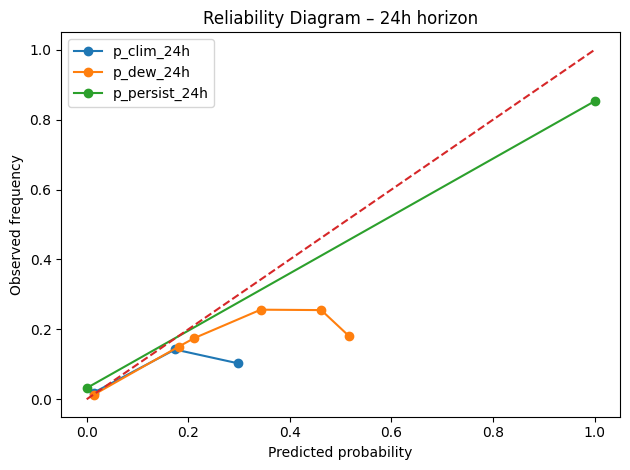

Saved: baseline_plots/roc_3h.png


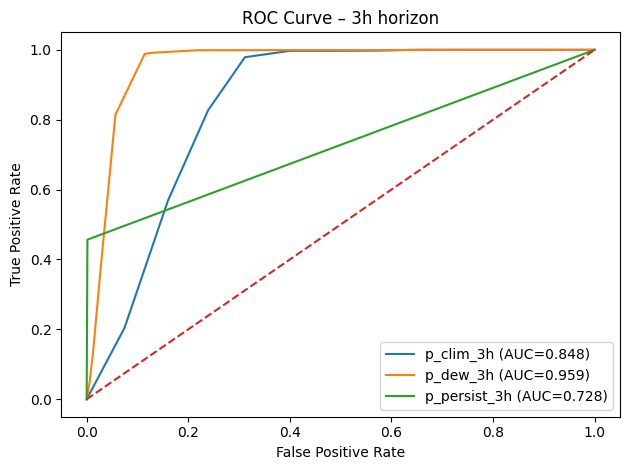

Saved: baseline_plots/roc_6h.png


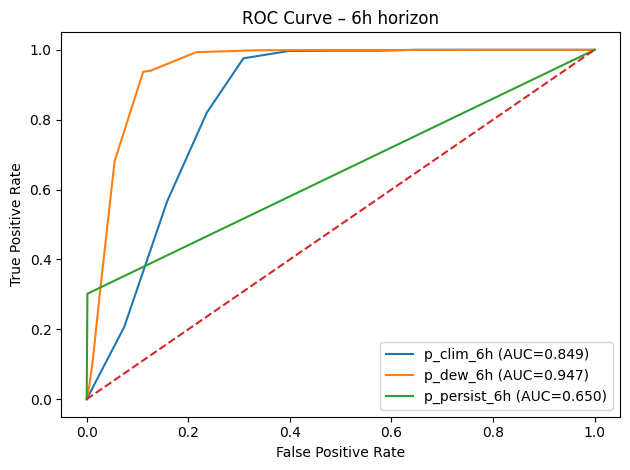

Saved: baseline_plots/roc_12h.png


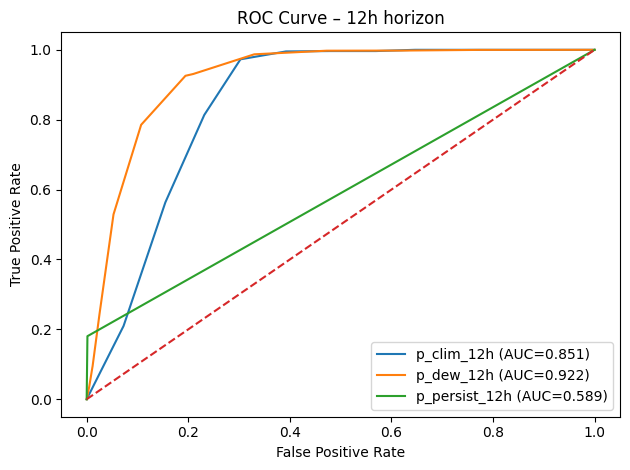

Saved: baseline_plots/roc_24h.png


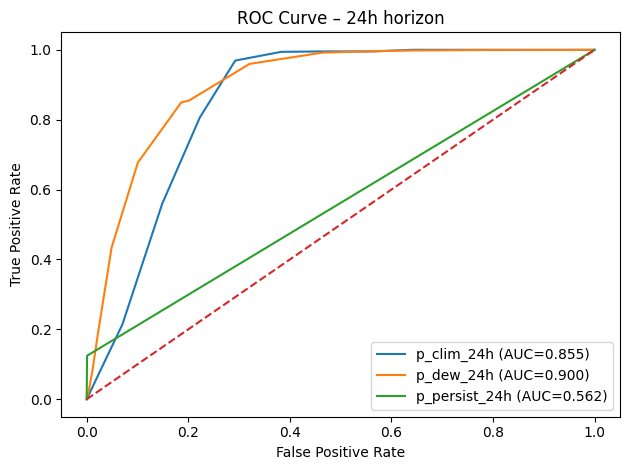

Saved: baseline_plots/pr_3h.png


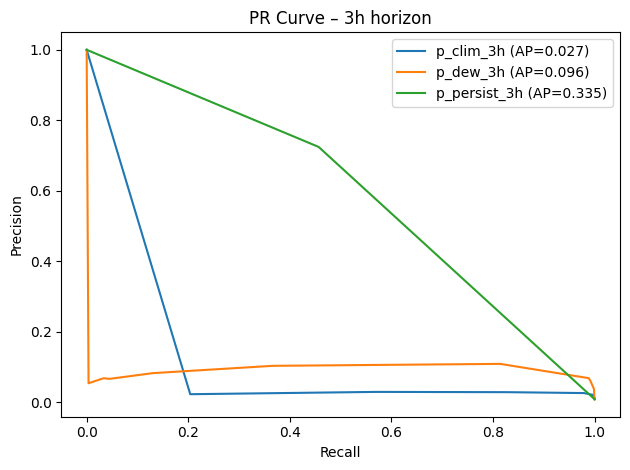

Saved: baseline_plots/pr_6h.png


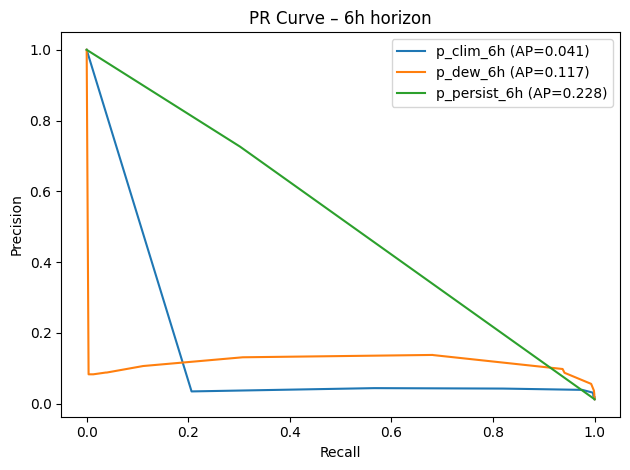

Saved: baseline_plots/pr_12h.png


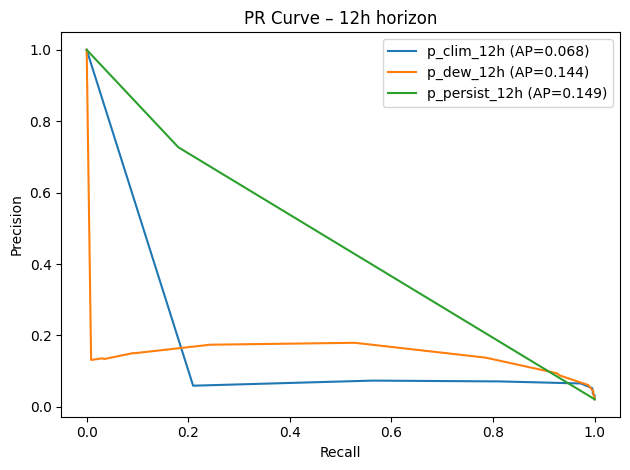

Saved: baseline_plots/pr_24h.png


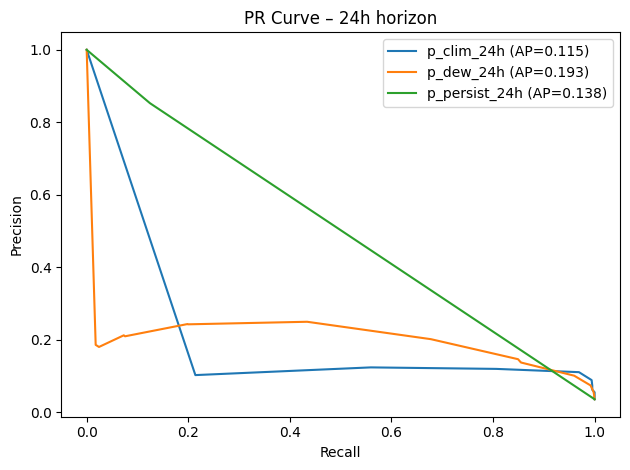

In [4]:
# Create folder for saving plots

PLOT_DIR = "baseline_plots"
os.makedirs(PLOT_DIR, exist_ok=True)

print(f"Saving all plots to: {PLOT_DIR}/")

# Load baseline data

HORIZONS = [3, 6, 12, 24]
baseline_df = pd.read_csv("frost_baselines_test.csv", parse_dates=["Datetime"])

# Helper: ECE

def compute_ece(y_true, y_prob, n_bins=10):
    y_true = np.asarray(y_true)
    y_prob = np.asarray(y_prob)

    mask = ~np.isnan(y_prob)
    y_true = y_true[mask]
    y_prob = y_prob[mask]

    bins = np.linspace(0, 1, n_bins + 1)
    bin_ids = np.digitize(y_prob, bins) - 1

    ece = 0
    n = len(y_true)

    for b in range(n_bins):
        in_bin = bin_ids == b
        if not np.any(in_bin):
            continue
        prob_avg = y_prob[in_bin].mean()
        freq_obs = y_true[in_bin].mean()
        ece += (in_bin.sum() / n) * abs(freq_obs - prob_avg)

    return ece


# Evaluation function

def evaluate_model_for_horizon(df, H, prob_col):
    label_col = f"frost_next_{H}h"

    sub = df[[label_col, prob_col]].dropna()
    y_true = sub[label_col].values
    y_prob = sub[prob_col].values

    brier = brier_score_loss(y_true, y_prob)
    roc_auc = roc_auc_score(y_true, y_prob) if len(np.unique(y_true)) == 2 else np.nan
    pr_auc = average_precision_score(y_true, y_prob)
    ece = compute_ece(y_true, y_prob)

    return {
        "horizon": H,
        "model": prob_col,
        "brier": brier,
        "roc_auc": roc_auc,
        "pr_auc": pr_auc,
        "ece": ece,
    }


# Compute baseline metrics

results = []
for H in HORIZONS:
    for model_col in [f"p_clim_{H}h", f"p_dew_{H}h", f"p_persist_{H}h"]:
        res = evaluate_model_for_horizon(baseline_df, H, model_col)
        results.append(res)

metrics_df = pd.DataFrame(results)
display(metrics_df)


# 1. BAR PLOTS (Brier, ECE, ROC-AUC, PR-AUC)

def plot_metric_bar(metrics_df, H, metric_name, ylabel=""):
    sub = metrics_df[metrics_df["horizon"] == H]

    plt.figure()
    plt.bar(sub["model"], sub[metric_name])
    plt.title(f"{metric_name} – {H}h horizon")
    plt.xticks(rotation=45)
    plt.ylabel(ylabel)
    plt.tight_layout()

    # Save plot
    save_path = f"{PLOT_DIR}/{metric_name}_{H}h.png"
    plt.savefig(save_path, dpi=200)
    print("Saved:", save_path)

    plt.show()


for H in HORIZONS:
    plot_metric_bar(metrics_df, H, "brier", "Brier score (lower=better)")
    plot_metric_bar(metrics_df, H, "ece", "ECE (lower=better)")
    plot_metric_bar(metrics_df, H, "roc_auc", "ROC-AUC (higher=better)")
    plot_metric_bar(metrics_df, H, "pr_auc", "PR-AUC (higher=better)")


# 2. RELIABILITY DIAGRAMS

def plot_reliability(df, H):
    label_col = f"frost_next_{H}h"
    model_cols = [f"p_clim_{H}h", f"p_dew_{H}h", f"p_persist_{H}h"]

    plt.figure()

    for col in model_cols:
        sub = df[[label_col, col]].dropna()
        y_true = sub[label_col]
        y_prob = sub[col]

        if len(np.unique(y_true)) < 2:
            continue

        frac_pos, mean_pred = calibration_curve(y_true, y_prob, n_bins=10)
        plt.plot(mean_pred, frac_pos, marker="o", label=col)

    plt.plot([0, 1], [0, 1], "--")
    plt.xlabel("Predicted probability")
    plt.ylabel("Observed frequency")
    plt.title(f"Reliability Diagram – {H}h horizon")
    plt.legend()
    plt.tight_layout()

    save_path = f"{PLOT_DIR}/reliability_{H}h.png"
    plt.savefig(save_path, dpi=200)
    print("Saved:", save_path)

    plt.show()


for H in HORIZONS:
    plot_reliability(baseline_df, H)


# 3. ROC CURVES

def plot_roc(df, H):
    label_col = f"frost_next_{H}h"
    model_cols = [f"p_clim_{H}h", f"p_dew_{H}h", f"p_persist_{H}h"]

    plt.figure()

    for col in model_cols:
        sub = df[[label_col, col]].dropna()
        y_true = sub[label_col]
        y_prob = sub[col]

        if len(np.unique(y_true)) < 2:
            continue

        fpr, tpr, _ = roc_curve(y_true, y_prob)
        auc = roc_auc_score(y_true, y_prob)
        plt.plot(fpr, tpr, label=f"{col} (AUC={auc:.3f})")

    plt.plot([0, 1], [0, 1], "--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve – {H}h horizon")
    plt.legend()
    plt.tight_layout()

    save_path = f"{PLOT_DIR}/roc_{H}h.png"
    plt.savefig(save_path, dpi=200)
    print("Saved:", save_path)

    plt.show()


for H in HORIZONS:
    plot_roc(baseline_df, H)


# 4. PRECISION–RECALL CURVES

def plot_pr(df, H):
    label_col = f"frost_next_{H}h"
    model_cols = [f"p_clim_{H}h", f"p_dew_{H}h", f"p_persist_{H}h"]

    plt.figure()

    for col in model_cols:
        sub = df[[label_col, col]].dropna()
        y_true = sub[label_col]
        y_prob = sub[col]

        if len(np.unique(y_true)) < 2:
            continue

        precision, recall, _ = precision_recall_curve(y_true, y_prob)
        ap = average_precision_score(y_true, y_prob)
        plt.plot(recall, precision, label=f"{col} (AP={ap:.3f})")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"PR Curve – {H}h horizon")
    plt.legend()
    plt.tight_layout()

    save_path = f"{PLOT_DIR}/pr_{H}h.png"
    plt.savefig(save_path, dpi=200)
    print("Saved:", save_path)

    plt.show()


for H in HORIZONS:
    plot_pr(baseline_df, H)

print(f"Success!")